In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import random
from torchvision import transforms
from torchvision.datasets import CIFAR10
from utils.vision import show_imageset
from data.clf_loaders import OpensetDataModule, CropDisease
from data.clf_loaders import CropDiseaseDataModule
from data.ood_loaders import OpensetOODDataModule, CropDiseaseOODDataModule
from config import PATH_LOG, PATH_MODEL, PATH_DATA_FARMSALL


CWD = Path.cwd()
openset = False


Global seed set to 42
Global seed set to 42


In [2]:
size, crop_size = 32, 32
transform = {'train': transforms.Compose([transforms.Resize(size),
                                    transforms.CenterCrop(crop_size),
                                    transforms.ToTensor()])}
transform['valid'] = transform['train']

if openset:
    dm = OpensetDataModule(transform=transform)
else:
    dm = CropDiseaseDataModule(transform=transform)
    # dm.prepare_data()

dm.setup('fit')
dm.setup('test')
train_set = dm.trainset
test_set = dm.testset
class_names = train_set.classes
idx_to_class = {value: name for name, value in train_set.class_to_idx.items()}

## 8종 딸기 병해 이미지 예시 확인

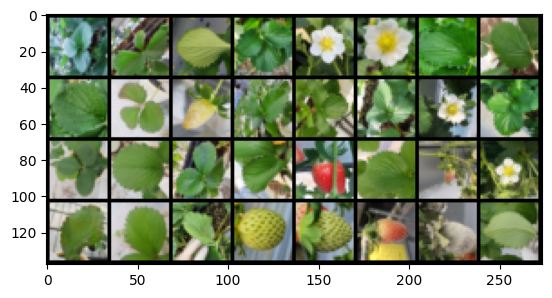

In [3]:
indices = random.sample(range(0, len(train_set)), 32) # list(range(32))
show_imageset(train_set, indices) #, mean=MEAN, std=STD)


 ## 딸기 분류 데이터 분포 확인

# of classes: 8


<Axes: title={'center': 'Testset: CropDisease\n 8 classes\n 33210 images'}, xlabel='name'>

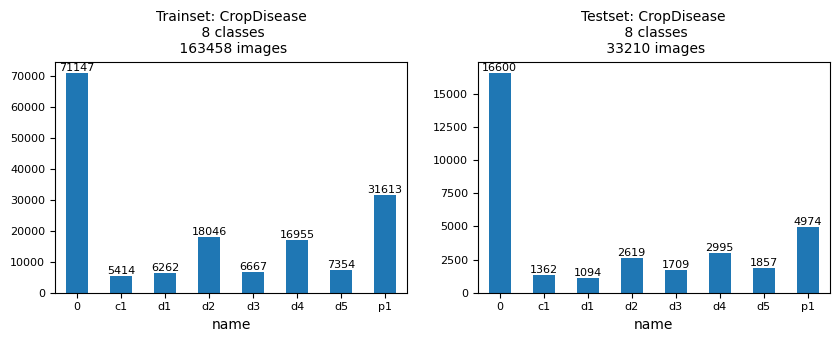

In [4]:
import matplotlib.pyplot as plt
from utils.dataset import check_balanced
from utils.plots import plot_bar

# Check if the set is balanced. Otherwise, subsample to be balanced.
print('# of classes:', len(idx_to_class))

counts = {idx_to_class[idx]: value for idx, value in check_balanced(train_set).items()}
df_train = pd.DataFrame.from_dict(counts, orient='index').reset_index()
df_train.columns = ['name', 'count']
counts = {idx_to_class[idx]: value for idx, value in check_balanced(test_set).items()}
df_test = pd.DataFrame.from_dict(counts, orient='index').reset_index()
df_test.columns = ['name', 'count']

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
plot_bar(df_train.sort_values(by='name'), col_x='name', ax=axes[0],
            title=f'Trainset: {train_set.__class__.__name__}\n {len(class_names)} classes\n {len(train_set)} images',
            title_attr={'fontsize': 10, 'fontweight': 'medium'}, fontsize=8)
plot_bar(df_test.sort_values(by='name'), col_x='name', ax=axes[1],
            title=f'Testset: {test_set.__class__.__name__}\n {len(class_names)} classes\n {len(test_set)} images',
            title_attr={'fontsize': 10, 'fontweight': 'medium'}, fontsize=8)



In [5]:
if openset:
    dm_ood = OpensetOODDataModule(transform=transform)
else:
    dm_ood = CropDiseaseOODDataModule(transform=transform)
dm_ood.setup('fit')
dm_ood.setup('test')
ood_train_set = dm_ood.trainset
ood_test_set = dm_ood.testset


Files already downloaded and verified
Files already downloaded and verified


 ## 딸기8종(IN-distribution) 과 OOD셋 분포 비교

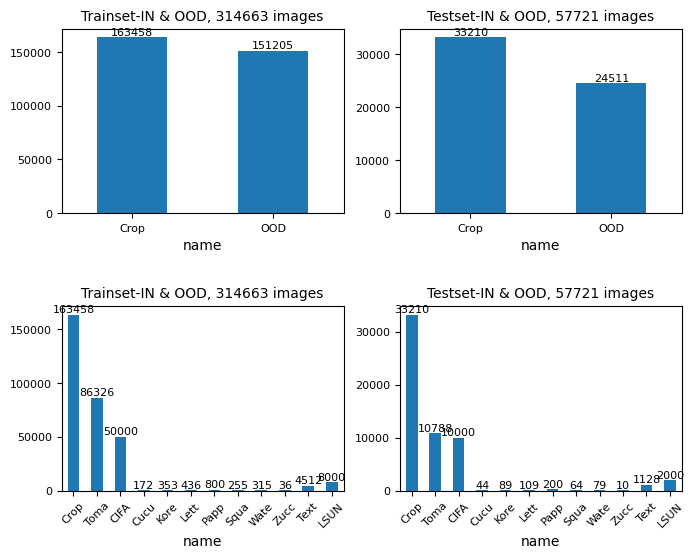

In [6]:
counts_train, counts_test = dm_ood.counts
counts_train = {name[:4]:value for name, value in counts_train.items()}
counts_test = {name[:4]:value for name, value in counts_test.items()}
df_train = pd.DataFrame({'name': list(counts_train.keys()), 'count': list(counts_train.values())})
df_test = pd.DataFrame({'name': list(counts_test.keys()), 'count': list(counts_test.values())})
df_train_in_ood = pd.DataFrame({'name': [list(counts_train.keys())[0], 'OOD'], 'count': [list(counts_train.values())[0], df_train['count'][1:].sum()]})
df_test_in_ood = pd.DataFrame({'name': [list(counts_test.keys())[0], 'OOD'], 'count': [list(counts_test.values())[0], df_test['count'][1:].sum()]})

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8,6))
plot_bar(df_train_in_ood, col_x='name', ax=axes[0,0],
            title=f'Trainset-IN & OOD, {df_train_in_ood["count"].sum()} images',
            title_attr={'fontsize': 10, 'fontweight': 'medium'}, fontsize=8)
plot_bar(df_test_in_ood, col_x='name', ax=axes[0,1],
            title=f'Testset-IN & OOD, {df_test_in_ood["count"].sum()} images',
            title_attr={'fontsize': 10, 'fontweight': 'medium'}, fontsize=8 )
plot_bar(df_train, col_x='name', ax=axes[1,0], x_rot=45,
            title=f'Trainset-IN & OOD, {df_train["count"].sum()} images',
            title_attr={'fontsize': 10, 'fontweight': 'medium'}, fontsize=8 )
plot_bar(df_test, col_x='name', ax=axes[1,1], x_rot=45,
            title=f'Testset-IN & OOD, {df_test["count"].sum()} images',
            title_attr={'fontsize': 10, 'fontweight': 'medium'}, fontsize=8 )
plt.subplots_adjust(hspace=0.5)

## Optional: OOD detector 학습/평가시 사용할 데이터 비율 확인
비율을 반으로 줄여도 성능에 차이는 없어보임.

In [39]:
subset_ratio = 0.5
trainloader = dm_ood.train_dataloader(subset=subset_ratio)
testloader = dm_ood.test_dataloader(subset=subset_ratio)

<Axes: title={'center': 'Testset-IN & OOD, 28916 images'}, xlabel='name'>

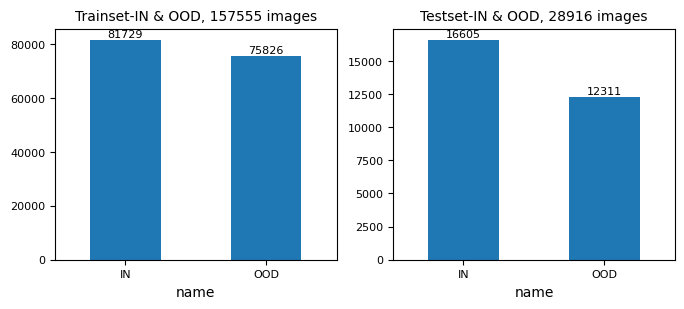

In [55]:
train_counts = np.array([len(trainloader.dataset.dataset.datasets[0]), len(trainloader.dataset.dataset.datasets[1])])*subset_ratio
test_counts = np.array([len(testloader.dataset.dataset.datasets[0]), len(testloader.dataset.dataset.datasets[1])])*subset_ratio
df_train_in_ood = pd.DataFrame({'name': ['IN', 'OOD'], 'count': train_counts.astype(int)})
df_test_in_ood = pd.DataFrame({'name': ['IN', 'OOD'], 'count': test_counts.astype(int)})
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,3))
plot_bar(df_train_in_ood, col_x='name', ax=axes[0],
            title=f'Trainset-IN & OOD, {df_train_in_ood["count"].sum()} images',
            title_attr={'fontsize': 10, 'fontweight': 'medium'}, fontsize=8)
plot_bar(df_test_in_ood, col_x='name', ax=axes[1],
            title=f'Testset-IN & OOD, {df_test_in_ood["count"].sum()} images',
            title_attr={'fontsize': 10, 'fontweight': 'medium'}, fontsize=8 )